In [1]:
%matplotlib inline
import flopy
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pathlib as pl
import xarray as xa

In [2]:
fpth = pl.Path("data/mcdonald_valley_truth.nc")

In [3]:
nc_ds = xa.open_dataset(fpth)

In [4]:
nc_ds

<xarray.Dataset> Size: 249kB
Dimensions:        (y: 40, x: 25)
Coordinates:
  * x              (x) float64 200B 250.0 750.0 1.25e+03 ... 1.175e+04 1.225e+04
  * y              (y) float64 320B 1.975e+04 1.925e+04 ... 750.0 250.0
Data variables: (12/31)
    bottom_layer1  (y, x) float64 8kB ...
    bottom_layer2  (y, x) float64 8kB ...
    bottom_layer3  (y, x) float64 8kB ...
    bottom_layer4  (y, x) float64 8kB ...
    bottom_layer5  (y, x) float64 8kB ...
    head_layer1    (y, x) float64 8kB ...
    ...             ...
    clay_kv        (y, x) float64 8kB ...
    znode_layer1   (y, x) float64 8kB ...
    znode_layer2   (y, x) float64 8kB ...
    znode_layer3   (y, x) float64 8kB ...
    znode_layer4   (y, x) float64 8kB ...
    znode_layer5   (y, x) float64 8kB ...

In [5]:
name = "mv"
ws = pl.Path("mv")

## Define discretization

In [6]:
top = nc_ds["top_layer1"].values + 2
top[nc_ds["lake_location"].values == 1] = 11

In [7]:
nlay = 5
nrow, ncol = top.shape
nlay, nrow, ncol

(5, 40, 25)

In [8]:
shape3d = (nlay, nrow, ncol)
shape2d = (nrow, ncol)

In [9]:
delr = delc = 500.

In [10]:
botm = [
    nc_ds["bottom_layer1"].values,
    nc_ds["bottom_layer2"].values,
    nc_ds["bottom_layer3"].values,
    nc_ds["bottom_layer4"].values,
    nc_ds["bottom_layer5"].values,
]

In [11]:
lake_location = nc_ds["lake_location"].values

In [12]:
nper = 4
tdis_ds = [
    (1.0, 1, 1),
    (1.0, 1, 1),
    (1.0, 1, 1),
    (1.0, 1, 1),
]

## Define starting heads

In [13]:
strt = [
    nc_ds["head_layer1"].values,
    nc_ds["head_layer2"].values,
    nc_ds["head_layer3"].values,
    nc_ds["head_layer4"].values,
    nc_ds["head_layer5"].values,
]

## Define aquifer properties 

In [14]:
kvkh_ratio = 0.4

In [15]:
lake_location = nc_ds["lake_location"].to_numpy()

In [16]:
clay_location = nc_ds["clay_location"].to_numpy()

In [17]:
kh3 = nc_ds["clay_kv"].to_numpy()
kh3[clay_location == 0] = nc_ds["hyat"].values[clay_location == 0]

In [18]:
kv3 = nc_ds["clay_kv"].to_numpy()
kv3[clay_location == 0] = nc_ds["hyat"].values[clay_location == 0] * kvkh_ratio

In [19]:
k = np.array([nc_ds["hyat"].to_numpy() for klay in range(nlay)])
k33 = np.array([nc_ds["hyat"].to_numpy() * kvkh_ratio for k in range(nlay)])

In [20]:
k[2, :, :] = kh3
k33[2, :, :] = kv3

In [21]:
k1 = k[0, :, :]
k1[lake_location == 1] = 2000000.0
k[0, :, :] = k1

In [22]:
k1 = k33[0, :, :]
k1[lake_location == 1] = 2000000.0
k33[0, :, :] = k1

## Define the recharge

In [23]:
recharge = np.full(shape2d, 0.00365, dtype=float)
recharge[lake_location == 1] = 0.00205

## Define the river

In [24]:
nriv = 18
stage = np.linspace(1.75, 0.05, nriv)
stage

array([1.75, 1.65, 1.55, 1.45, 1.35, 1.25, 1.15, 1.05, 0.95, 0.85, 0.75,
       0.65, 0.55, 0.45, 0.35, 0.25, 0.15, 0.05])

In [25]:
riv_bndname = ["PF", "PF"] + ["RIV" for i in range(nriv - 2)]

In [26]:
river_spd = [(0, i + 22, 8, float(stage[i]), 1e5, float(stage[i]) - 1., riv_bndname[i]) for i in range(nriv)]
river_spd

[(0, 22, 8, 1.75, 100000.0, 0.75, 'PF'),
 (0, 23, 8, 1.65, 100000.0, 0.6499999999999999, 'PF'),
 (0, 24, 8, 1.55, 100000.0, 0.55, 'RIV'),
 (0, 25, 8, 1.45, 100000.0, 0.44999999999999996, 'RIV'),
 (0, 26, 8, 1.35, 100000.0, 0.3500000000000001, 'RIV'),
 (0, 27, 8, 1.25, 100000.0, 0.25, 'RIV'),
 (0, 28, 8, 1.15, 100000.0, 0.1499999999999999, 'RIV'),
 (0, 29, 8, 1.05, 100000.0, 0.050000000000000044, 'RIV'),
 (0, 30, 8, 0.9500000000000001, 100000.0, -0.04999999999999993, 'RIV'),
 (0, 31, 8, 0.8500000000000001, 100000.0, -0.1499999999999999, 'RIV'),
 (0, 32, 8, 0.7500000000000001, 100000.0, -0.2499999999999999, 'RIV'),
 (0, 33, 8, 0.6500000000000001, 100000.0, -0.34999999999999987, 'RIV'),
 (0, 34, 8, 0.55, 100000.0, -0.44999999999999996, 'RIV'),
 (0, 35, 8, 0.4500000000000002, 100000.0, -0.5499999999999998, 'RIV'),
 (0, 36, 8, 0.3500000000000001, 100000.0, -0.6499999999999999, 'RIV'),
 (0, 37, 8, 0.2500000000000002, 100000.0, -0.7499999999999998, 'RIV'),
 (0, 38, 8, 0.15000000000000013, 100

## Define the wells

In [27]:
well_spd = {
    1: [
        (4, 5, 14, -67000),
        (4, 34, 15, -268000),
    ],
    2: [
        (4, 5, 14, -67000),
        (4, 32, 5, -268000),
    ],
    3: [
        (4, 5, 14, -67000),
    ],
}

## Define the drain for the extra run

In [28]:
drn_spd = {
    3: [
        (0, 22, 19, 2.0, 4e6)
    ],
}

## Define the head observations

In [29]:
obs_rc_locs = [
    (2, 17),
    (3, 10),
    (6, 20),
    (12, 22),
    (14, 11),
    (16, 18),
    (17, 1),
    (18, 6),
    (19, 11),
    (18, 22),
    (26, 5),
    (27, 11),
    (28, 23),
    (30, 6),
    (33, 14),
    (36, 1),
    (37, 22),
]

In [30]:
np.array(botm)[:, 3, 10]

array([  -5.  ,  -15.  ,  -50.35, -139.35, -227.22])

In [31]:
well_depth = [
    -200.74, -100.00, -100.00, -100.00, -224.62, 
    -100.00, -100.00, -100.00, -100.00, -100.00,
    -100.00, -100.00, -100.00, -100.00, -233.22,
    -100.00, -100.00,
]

In [32]:
wt_obs = []
aq_layer = []
aq_obs = []
for idx, (i, j) in enumerate(obs_rc_locs):
    iloc = (i, j)
    tag = "head_layer1"
    wt_obs.append(float(nc_ds[tag].values[iloc]))
    wz = well_depth[idx]
    zcell = np.array(botm)[:, i, j]
    klay = 0
    for kk in range(1, nlay):
        z0 = zcell[kk - 1]
        z1 = zcell[kk]
        if wz < z0 and wz >= z1:
            klay = kk
            break
    tag = f"head_layer{klay + 1}"
    aq_layer.append(klay)
    aq_obs.append(float(nc_ds[tag].values[iloc]))

In [33]:
print(wt_obs)

[12.05, 11.63, 12.15, 11.44, 10.86, 10.8, 9.16, 8.82, 8.86, 10.65, 4.26, 4.19, 7.57, 2.7, 4.59, 2.76, 6.23]


In [34]:
print(aq_layer)

[4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3]


In [35]:
print(aq_obs)

[11.85, 11.35, 11.83, 11.43, 10.5, 10.79, 9.13, 8.79, 8.83, 10.64, 4.25, 4.18, 7.56, 2.69, 4.57, 2.73, 6.22]


In [36]:
cal_loc_wt = [(0, i, j) for i, j in obs_rc_locs]

In [37]:
cal_loc_aq = [(aq_layer[idx], i, j) for idx, (i, j) in enumerate(obs_rc_locs)]

In [38]:
obs_loc = {}
obs_loc["mv.gwf.wt.csv"] = [(f"WT{idx + 1: 02d}", "HEAD", (0, i, j)) for idx, (i, j) in enumerate(obs_rc_locs)]

In [39]:
obs_loc["mv.gwf.aq.csv"] = [(f"AQ{idx + 1: 02d}", "HEAD", (aq_layer[idx], i, j)) for idx, (i, j) in enumerate(obs_rc_locs)]

In [40]:
obs_loc["mv.gwf.scenario.csv"] = [
    ("Lake-N", "HEAD", (0, 3, 3)),
    ("Lake-S", "HEAD", (0, 15, 8)),
    ("Reilly", "HEAD", (4, 5, 14)),
    ("V1", "HEAD", (4, 34, 15)),
    ("V2", "HEAD", (4, 32, 5)),
    ("DW", "HEAD", (0, 22, 19)),
]


In [41]:
obs_loc

{'mv.gwf.wt.csv': [('WT 1', 'HEAD', (0, 2, 17)),
  ('WT 2', 'HEAD', (0, 3, 10)),
  ('WT 3', 'HEAD', (0, 6, 20)),
  ('WT 4', 'HEAD', (0, 12, 22)),
  ('WT 5', 'HEAD', (0, 14, 11)),
  ('WT 6', 'HEAD', (0, 16, 18)),
  ('WT 7', 'HEAD', (0, 17, 1)),
  ('WT 8', 'HEAD', (0, 18, 6)),
  ('WT 9', 'HEAD', (0, 19, 11)),
  ('WT 10', 'HEAD', (0, 18, 22)),
  ('WT 11', 'HEAD', (0, 26, 5)),
  ('WT 12', 'HEAD', (0, 27, 11)),
  ('WT 13', 'HEAD', (0, 28, 23)),
  ('WT 14', 'HEAD', (0, 30, 6)),
  ('WT 15', 'HEAD', (0, 33, 14)),
  ('WT 16', 'HEAD', (0, 36, 1)),
  ('WT 17', 'HEAD', (0, 37, 22))],
 'mv.gwf.aq.csv': [('AQ 1', 'HEAD', (4, 2, 17)),
  ('AQ 2', 'HEAD', (3, 3, 10)),
  ('AQ 3', 'HEAD', (3, 6, 20)),
  ('AQ 4', 'HEAD', (3, 12, 22)),
  ('AQ 5', 'HEAD', (4, 14, 11)),
  ('AQ 6', 'HEAD', (3, 16, 18)),
  ('AQ 7', 'HEAD', (3, 17, 1)),
  ('AQ 8', 'HEAD', (3, 18, 6)),
  ('AQ 9', 'HEAD', (3, 19, 11)),
  ('AQ 10', 'HEAD', (3, 18, 22)),
  ('AQ 11', 'HEAD', (3, 26, 5)),
  ('AQ 12', 'HEAD', (3, 27, 11)),
  ('AQ 13',

## Build the model

In [42]:
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws)

In [43]:
tdis = flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units="DAY")

In [44]:
ims = flopy.mf6.ModflowIms(sim, complexity="simple", outer_maximum=200, inner_maximum=100, outer_dvclose=1e-5, inner_dvclose=1e-6)

In [45]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

In [46]:
dis = flopy.mf6.ModflowGwfdis(gwf, length_units="FEET", nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=top, botm=botm)

In [47]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)

In [48]:
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, k=k, k33=k33)

In [49]:
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)

In [50]:
riv_obs = {"riv.obs.csv": [("PF", "RIV", "PF"), ("RIVFLOW", "RIV", "RIV")]}

In [51]:
riv = flopy.mf6.ModflowGwfriv(gwf, boundnames=True, 
                              print_flows=True, 
                              maxbound=nriv, 
                              stress_period_data=river_spd, 
                              observations=riv_obs
                             )

In [52]:
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=well_spd, maxbound=2, pname="pwell")

In [53]:
drn = flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=drn_spd, maxbound=1, pname="dewater")

In [54]:
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{name}.hds",
    budget_filerecord=f"{name}.cbc",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

In [55]:
gwf_obs = flopy.mf6.ModflowUtlobs(gwf, print_input=True, continuous=obs_loc)

In [56]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mv...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package riv_0...
    writing package obs_0...
    writing package pwell...
    writing package dewater...
    writing package oc...
    writing package obs_1...


In [57]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../miniforge3/envs/gw3099/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 12/05/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Dec  5 2024 13:34:29 with GCC version 13.3.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
u

(True, [])

## Plot the results

### Model Properties

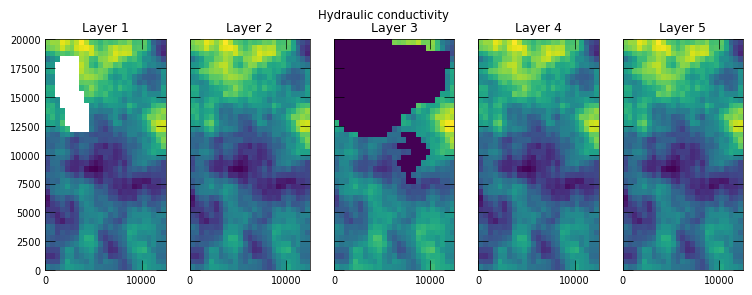

In [58]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Hydraulic conductivity")

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(k[idx], masked_values=[2000000.0])
        ax.set_title(f"Layer {idx + 1}")

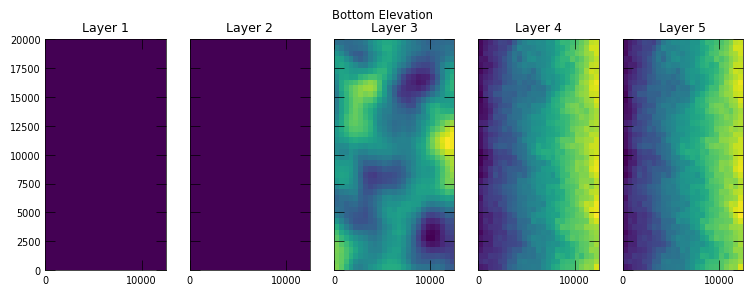

In [59]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Bottom Elevation")

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(botm[idx])
        ax.set_title(f"Layer {idx + 1}")

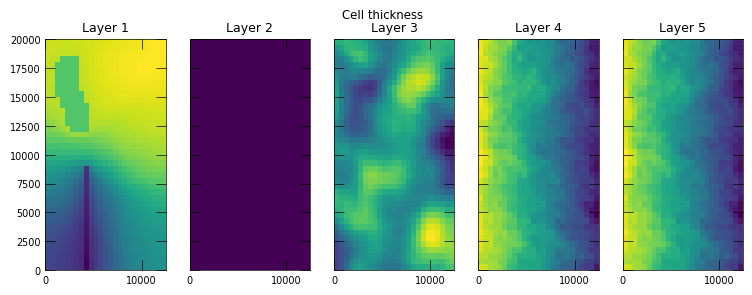

In [60]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Cell thickness")
    z = gwf.modelgrid.cell_thickness

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(z[idx])
        ax.set_title(f"Layer {idx + 1}")

### Simulated Heads and Drawdown

In [61]:
levels = np.arange(2, 20., 2)

#### Calibration

In [62]:
hds = gwf.output.head().get_data(totim=1.0)

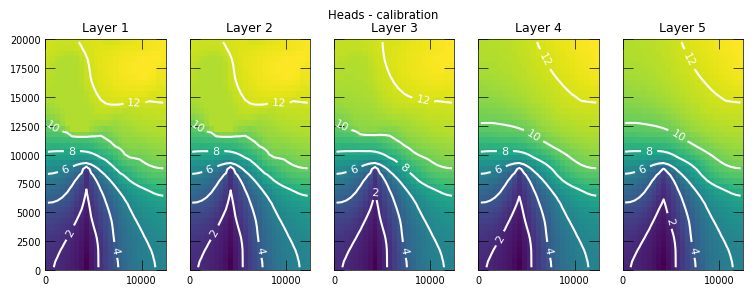

In [63]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Heads - calibration")

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(hds)
        cs = mm.contour_array(hds, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

In [64]:
v = gwf.output.budget().get_data(text="riv", totim=1.0)[0]["q"]
print(f"River infiltration: {np.all(v > 0)}\n{v}")

River infiltration: False
[-80179.15438414 -59052.97861552 -61816.92904938 -62829.93298655
 -57903.34192829 -51850.49801825 -47983.49368228 -44423.45876976
 -41754.34605666 -39784.4952349  -40126.63383712 -40101.13195655
 -42470.55304769 -42681.49748603 -41952.40933172 -41776.68764657
 -42248.27507265 -47564.2582153 ]


##### Calculate the residuals

In [65]:
sim_wt = np.array([hds[idx] for idx in cal_loc_wt])

In [66]:
resid_wt = sim_wt - np.array(wt_obs)
resid_wt

array([ 0.60899852,  0.64003286,  0.67148355,  0.36595101,  0.34032555,
        0.25298664, -0.22166929, -0.28556032, -0.2225372 ,  0.25416984,
       -0.63265234, -0.56785379, -0.10995624, -0.5484651 , -0.37531105,
       -0.54886364, -0.21354061])

In [67]:
sim_aq = np.array([hds[idx] for idx in cal_loc_aq])

In [68]:
resid_aq = sim_wt - np.array(aq_obs)
resid_aq

array([ 0.80899852,  0.92003286,  0.99148355,  0.37595101,  0.70032555,
        0.26298664, -0.19166929, -0.25556032, -0.1925372 ,  0.26416984,
       -0.62265234, -0.55785379, -0.09995624, -0.5384651 , -0.35531105,
       -0.51886364, -0.20354061])

In [69]:
resid_gb = np.concatenate((resid_wt, resid_aq))

In [70]:
print(f"Water Table Statistics\nMean Error: {resid_wt.mean()} ft.\nRMSE:       {np.sqrt((resid_wt**2).sum()) / resid_wt.shape[0]} ft.")

Water Table Statistics
Mean Error: -0.03485068307328946 ft.
RMSE:       0.10707309025939045 ft.


In [71]:
print(f"Lower Aquifer Statistics\nMean Error: {resid_aq.mean()} ft.\nRMSE:       {np.sqrt((resid_aq**2).sum()) / resid_aq.shape[0]} ft.")

Lower Aquifer Statistics
Mean Error: 0.04632578751494609 ft.
RMSE:       0.1292722119386228 ft.


In [72]:
print(f"Global Statistics\nMean Error: {resid_gb.mean()} ft.\nRMSE:       {np.sqrt((resid_gb**2).sum()) / resid_gb.shape[0]} ft.")

Global Statistics
Mean Error: 0.005737552220828318 ft.
RMSE:       0.08392846870579698 ft.


##### Plot the residuals

In [73]:
xy = [(float(gwf.modelgrid.xcellcenters[i, j]), float(gwf.modelgrid.ycellcenters[i, j])) for i, j in obs_rc_locs]

In [74]:
x, y = np.array(xy)[:, 0], np.array(xy)[:, 1]

In [75]:
grid_x, grid_y = np.meshgrid(gwf.modelgrid.xycenters[0],
                             gwf.modelgrid.xycenters[1])

In [76]:
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)

In [77]:
interpolator = tri.LinearTriInterpolator(triang, resid_wt)
grid_resid_wt = interpolator(grid_x, grid_y)

In [78]:
interpolator = tri.LinearTriInterpolator(triang, resid_aq)
grid_resid_aq = interpolator(grid_x, grid_y)

In [79]:
resid_levels = np.arange(-2, 2.25, .25)

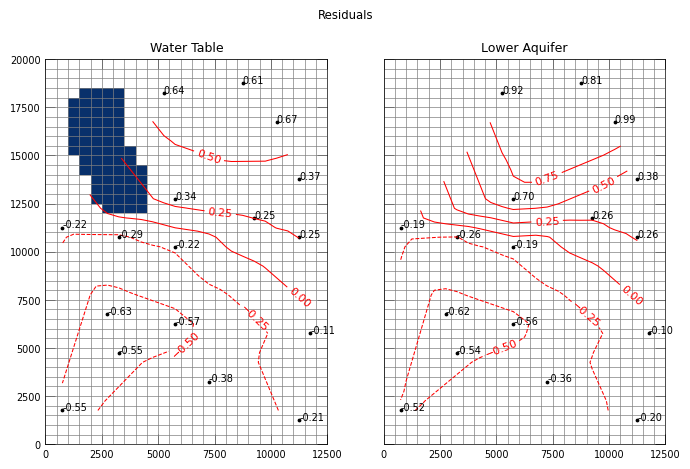

In [80]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
    fig.suptitle("Residuals")

    ax = axs[0]
    ax.set_xlim(0, 12500)
    ax.set_ylim(0, 20000)
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    mm.plot_array(lake_location, cmap="Blues_r", masked_values=[0])
    mm.plot_grid(lw=0.5, color="0.5")
    ax.scatter(x, y, s=3, c="black")
    for i, txt in enumerate(resid_wt):
        ax.annotate(f"{txt:.2f}", (x[i], y[i]))
    cs = ax.contour(grid_x, grid_y, grid_resid_wt, levels=resid_levels, linewidths=0.75, colors="red")
    plt.clabel(cs, inline=True, fontsize=8)
    ax.set_title("Water Table")

    ax = axs[1]
    ax.set_xlim(0, 12500)
    ax.set_ylim(0, 20000)
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    mm.plot_grid(lw=0.5, color="0.5")
    ax.scatter(x, y, s=3, c="black")
    for i, txt in enumerate(resid_aq):
        ax.annotate(f"{txt:.2f}", (x[i], y[i]), clip_on=False)
    cs = ax.contour(grid_x, grid_y, grid_resid_aq, levels=resid_levels, linewidths=0.75, colors="red")
    plt.clabel(cs, inline=True, fontsize=8)
    ax.set_title("Lower Aquifer")

**NOTE:** There is spatial bias in the simulated results (*i.e.*, residuals are positive in the Northeast and negative in the Southwest).

#### Case A

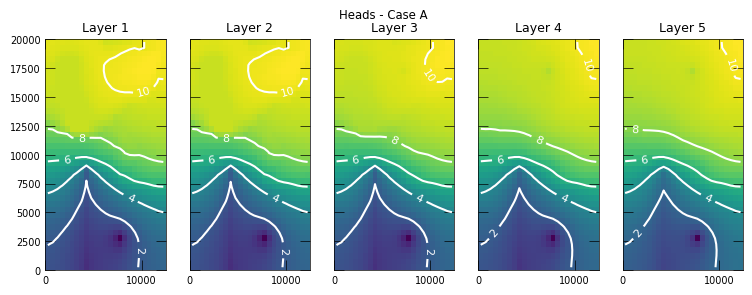

In [81]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Heads - Case A")
    hds = gwf.output.head().get_data(totim=2.0)

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(hds)
        cs = mm.contour_array(hds, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

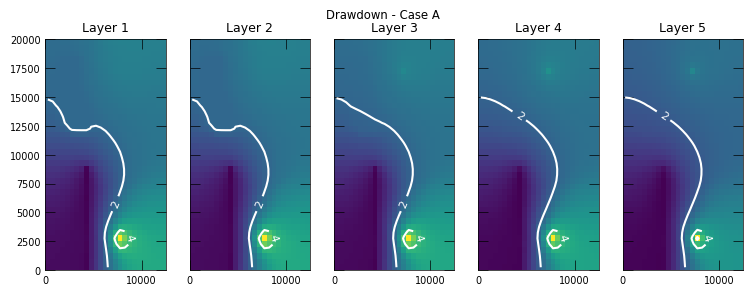

In [82]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Drawdown - Case A")
    ddn = gwf.output.head().get_data(totim=1.0) - gwf.output.head().get_data(totim=2.0) 

    ddn_max = ddn[:, 16, :].max()

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(ddn)
        cs = mm.contour_array(ddn, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

In [83]:
print(f"Maximum Drawdown: {ddn_max}")

Maximum Drawdown: 2.334454835755377


In [84]:
v = gwf.output.budget().get_data(text="riv", totim=2.0)[0]["q"]
print(f"Induced river infiltration: {np.all(v > 0)}\n{v}")

Induced river infiltration: False
[-61210.72008694 -44101.35734993 -45063.14871695 -44845.67159048
 -40424.812781   -34943.17932518 -30713.8990971  -26722.19826705
 -23616.98974417 -21096.27649183 -20164.41724116 -19644.84350066
 -20718.67962402 -21356.43484774 -21722.18787133 -22546.08720588
 -23952.2780036  -28656.89656611]


 #### Case B

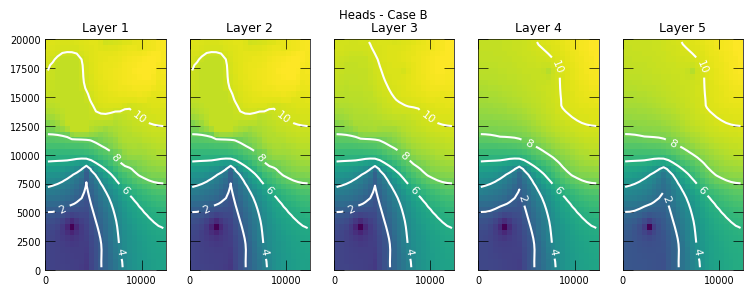

In [85]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Heads - Case B")
    hds = gwf.output.head().get_data(totim=3.0)

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(hds)
        cs = mm.contour_array(hds, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

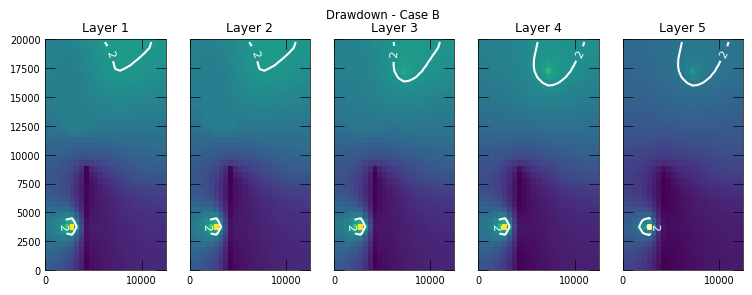

In [86]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Drawdown - Case B")
    ddn = gwf.output.head().get_data(totim=1.0) - gwf.output.head().get_data(totim=3.0) 
    
    ddn_max = ddn[:, 16, :].max()
    
    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(ddn)
        cs = mm.contour_array(ddn, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

In [87]:
print(f"Maximum Drawdown: {ddn_max}")

Maximum Drawdown: 1.5082372533627542


In [88]:
v = gwf.output.budget().get_data(text="riv", totim=3.0)[0]["q"]
print(f"Induced river infiltration: {np.all(v > 0)}\n{v}")

Induced river infiltration: False
[-64974.53691003 -46868.02923058 -47923.61718157 -47760.94515707
 -42903.03186157 -36810.51717189 -31716.41606177 -26114.32506519
 -20091.06279127 -14507.03221339 -11526.71759465 -12569.20130288
 -16905.93597314 -20643.0852861  -23438.09449838 -25804.35700552
 -27906.43628156 -33036.63746191]


#### Extra Run

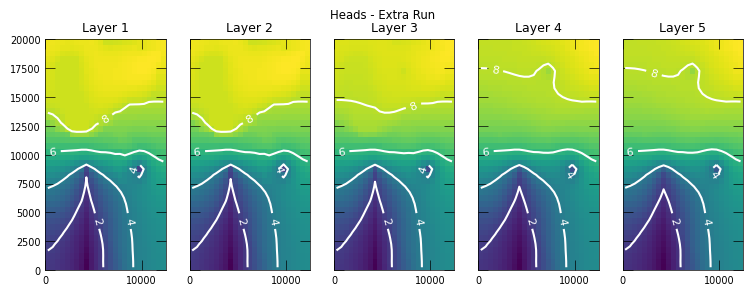

In [89]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Heads - Extra Run")
    hds = gwf.output.head().get_data(totim=4.0)

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(hds)
        cs = mm.contour_array(hds, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

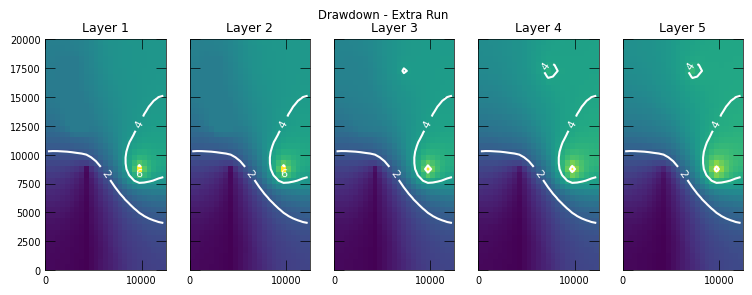

In [90]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Drawdown - Extra Run")
    ddn = gwf.output.head().get_data(totim=1.0) - gwf.output.head().get_data(totim=4.0) 
    
    ddn_max = ddn[:, 16, :].max()

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(ddn)
        cs = mm.contour_array(ddn, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

In [91]:
print(f"Maximum Drawdown: {ddn_max}")

Maximum Drawdown: 4.216022492951386


In [92]:
v = gwf.output.budget().get_data(text="riv", totim=4.0)[0]["q"]
print(f"Induced river infiltration: {np.all(v > 0)}\n{v}")

Induced river infiltration: False
[-52139.00561143 -38412.32217261 -40469.35126866 -41730.92184087
 -39181.43337567 -35689.95693081 -33566.08368665 -31614.81195289
 -30291.93833561 -29423.04405429 -30278.02693461 -30917.37860707
 -33418.90326463 -34257.98235779 -34249.59131579 -34622.11780842
 -35515.22760247 -40624.88294862]


### Streamflow results

In [93]:
df = riv.output.obs().get_dataframe()
df["PF"] /= -86400
df["RIVFLOW"] /= -86400
df["TOTAL"] = df["PF"] + df["RIVFLOW"]
df

,totim,PF,RIVFLOW,TOTAL
1970-01-02,1.0,1.611483,8.648935,10.260418
1970-01-03,2.0,1.218890,5.164213,6.383103
1970-01-04,3.0,1.294474,5.088627,6.383102
1970-01-05,4.0,1.048048,6.433468,7.481516


In [94]:
Q = df["TOTAL"].values
Q

array([10.26041754,  6.38310276,  6.38310161,  7.48151597])

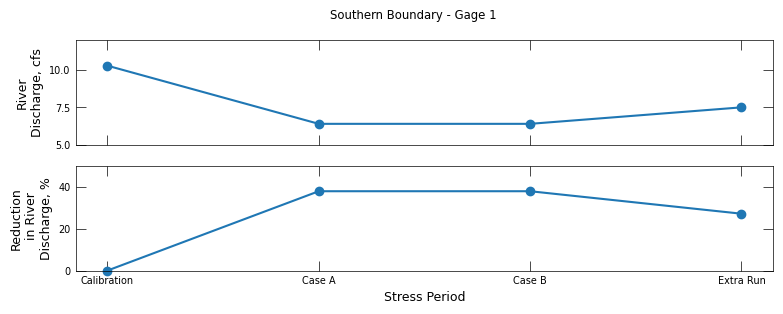

In [95]:
with flopy.plot.styles.USGSPlot():
    fig, axs = plt.subplots(2, 1, figsize=(9, 3), sharex=True)

    fig.suptitle("Southern Boundary - Gage 1")

    ax = axs[0]
    ax.set_ylim(5, 12)
    ax.plot(df["totim"], Q, ls="-", marker="o", clip_on=False)
    ax.set_ylabel("River\nDischarge, cfs")

    ax = axs[1]
    ax.set_ylim(0, 50)
    ax.plot(df["totim"], -100. * (Q - Q[0]) / Q[0], ls="-", marker="o", clip_on=False)
    ax.set_ylabel("Reduction\n in River\nDischarge, %")
    ax.set_xlabel("Stress Period")
    ax.set_xticks([1, 2, 3, 4], ["Calibration", "Case A", "Case B", "Extra Run"])


In [96]:
Q = df["PF"].values
Q

array([1.61148302, 1.21888979, 1.29447415, 1.04804778])

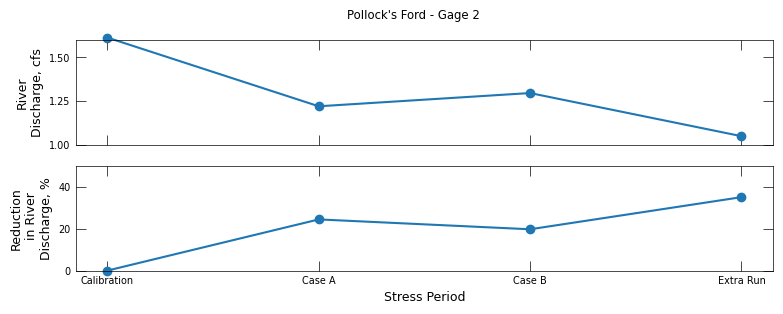

In [97]:
with flopy.plot.styles.USGSPlot():
    fig, axs = plt.subplots(2, 1, figsize=(9, 3), sharex=True)

    fig.suptitle("Pollock's Ford - Gage 2")

    ax = axs[0]
    ax.set_ylim(1, 1.6)
    ax.plot(df["totim"], Q, ls="-", marker="o", clip_on=False)
    ax.set_ylabel("River\nDischarge, cfs")

    ax = axs[1]
    ax.set_ylim(0, 50)
    ax.plot(df["totim"], -100. * (Q - Q[0]) / Q[0], ls="-", marker="o", clip_on=False)
    ax.set_ylabel("Reduction\n in River\nDischarge, %")
    ax.set_xlabel("Stress Period")
    ax.set_xticks([1, 2, 3, 4], ["Calibration", "Case A", "Case B", "Extra Run"])


### Lake stage

In [98]:
fpth = ws / "mv.gwf.scenario.csv"

In [99]:
df = flopy.utils.Mf6Obs(fpth).get_dataframe()
df

,totim,LAKE-N,LAKE-S,REILLY,V1,V2,DW
1970-01-02,1.0,11.422987,11.419040,11.948682,4.596436,2.069758,9.462838
1970-01-03,2.0,9.378715,9.375580,8.784170,-1.959846,1.737409,7.195342
1970-01-04,3.0,9.789776,9.786499,9.313022,4.131873,-2.742599,8.368722
1970-01-05,4.0,8.321096,8.318247,7.517823,3.448482,1.811885,2.043274


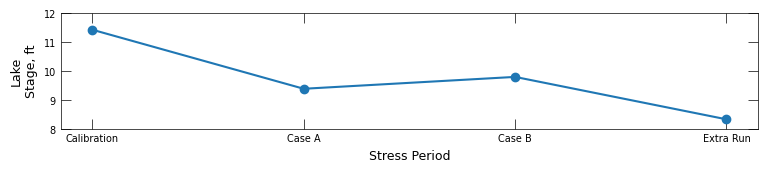

In [100]:
with flopy.plot.styles.USGSPlot():
    fig, ax = plt.subplots(1, 1, figsize=(9, 1.5))

    ax.plot(df["totim"], df["LAKE-N"], ls="-", marker="o",)
    ax.set_ylabel("Lake\nStage, ft")
    ax.set_xlabel("Stress Period")
    ax.set_xticks([1, 2, 3, 4], ["Calibration", "Case A", "Case B", "Extra Run"])
    ax.set_ylim(8, 12)
